# Transfer Learning

In [1]:
import sys
from functools import partial

import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

from Evaluation import get_confusion_matrix_for_model_and_data

sys.path.append("../src")

from tensorflow import keras
import tensorflow as tf
import numpy as np

from TrainProdecure import train_single_model
from ModelBuilder import get_FCN
from LoadData import get_all_datasets_test_train_np_arrays

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from LoadData import get_fcn_datasets_test_train_np_arrays, DATASETS_FCN

EPOCHS_PER_TRAINING = 30
# USED_DATASETS = get_fcn_datasets_test_train_np_arrays('../datasets/')
USED_DATASETS = get_all_datasets_test_train_np_arrays('../datasets/', ds_names=DATASETS_FCN[:3])
GENERATE_MODEL = partial(get_FCN, transfer_learning=True)
MODEL_NAME = 'FCN'
FINE_TUNE_LEARNING_RATE = 10e-3

In [3]:
def train_model_from_scratch(x_train, y_train, x_test, y_test, dataset_name):
    """
    Function to train a model from scratch on a given dataset
    :return: the trained model, the loss, the accuracy, and the history
    """
    input_size = x_train.shape[1]
    output_size = len(np.unique(y_train))

    scratch_model = GENERATE_MODEL(input_size, output_size)
    scratch_model.build(input_shape=(None, input_size, 1))

    return train_single_model(
        scratch_model, x_train, y_train, x_test, y_test,
        epochs=EPOCHS_PER_TRAINING, batch_size=None, model_name=MODEL_NAME, dataset_name=dataset_name
    )

In [4]:
def transfer_learning_model_one_dataset(x_train, y_train, x_test, y_test, dataset_name):
    input_size = x_train.shape[1]
    output_size = len(np.unique(y_train))

    model = GENERATE_MODEL(input_size, output_size)
    model.build(input_shape=(None, input_size, 1))

    return train_single_model(
        model, x_train, y_train, x_test, y_test,
        epochs=EPOCHS_PER_TRAINING, batch_size=25, model_name='FCN',
        dataset_name=dataset_name
    )

In [5]:
def two_confusion_matrices(confusion_matrix_1, model_name_1, confusion_matrix_2, model_name_2, dataset_name):
    plt.figure(figsize=(20, 10))
    plt.title(f'Transfer Learning for {dataset_name}')
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix_1, annot=True, fmt="d")
    plt.title(f"Confusion Matrix for {model_name_1}")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix_2, annot=True, fmt="d")
    plt.title(f"Confusion Matrix for {model_name_2}")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [6]:
def transfer_learning_for_all_datasets(used_datasets):
    """
    Function to train a model from scratch on a given dataset
    :return: the trained model, the loss, the accuracy, and the history
    """
    # Target ds for which it is fine-tuned:
    for dataset_name, data_dict in tqdm(used_datasets.items(), unit='datasets', desc='Transfer Learning for all datasets'):
        print(f"Training model targeting dataset {dataset_name}")

        x_train, y_train = data_dict['train_data']
        x_test, y_test = data_dict['test_data']

        # ds for pre-training:
        datasets_subset = {name: value for name, value in used_datasets.items() if name != dataset_name}
        for pre_train_ds_name, pre_train_data_dict in tqdm(datasets_subset.items(), unit='datasets', desc='Pre-training on different datasets'):
            print(f"Pre-training model on dataset {dataset_name}")

            pre_train_x_train, pre_train_y_train = pre_train_data_dict['train_data']
            pre_train_x_test, pre_train_y_test = pre_train_data_dict['test_data']

            # Training a model from scratch as a baseline:
            scratch_model, scratch_loss, scratch_accuracy, scratch_history = train_model_from_scratch(
                x_train, y_train, x_test, y_test, dataset_name
            )

            # Pre-training a model:
            pre_trained_model, _, _, _ = transfer_learning_model_one_dataset(
                pre_train_x_train, pre_train_y_train, pre_train_x_test, pre_train_y_test, pre_train_ds_name
            )

            # Fine-tuning:
            input_size = x_train.shape[1]
            output_size = len(np.unique(y_train))
            headless_model_layers = pre_trained_model.layers[:-1]
            fine_tuned_model = keras.Sequential([*headless_model_layers, keras.layers.Dense(output_size, activation='softmax')])
            fine_tuned_model.build(input_shape=(None, input_size, 1))
            train_single_model(
                fine_tuned_model, x_train, y_train, x_test, y_test,
                epochs=EPOCHS_PER_TRAINING, batch_size=25, model_name='FCN', dataset_name=dataset_name
            )

            # Compare confusion matrices:
            from_scratch_confusion_matrix = get_confusion_matrix_for_model_and_data(scratch_model, x_test, y_test)
            transfer_learned_confusion_matrix = get_confusion_matrix_for_model_and_data(pre_trained_model, x_test, y_test)

            two_confusion_matrices(
                from_scratch_confusion_matrix, 'Model trained from scratch',
                transfer_learned_confusion_matrix, f'Model pre-trained on {pre_train_ds_name}',
                dataset_name
            )


Transfer Learning for all datasets:   0%|          | 0/3 [00:00<?, ?datasets/s]

Training model targeting dataset cbf


Pre-training on different datasets:   0%|          | 0/2 [00:00<?, ?datasets/s]

Pre-training model on dataset cbf


Training FCN on cbf dataset: 0epoch [00:00, ?epoch/s]

29/29 [==============================] - 0s 5ms/step - loss: 0.8537 - accuracy: 0.4967


Training FCN on distal_phalanax_tw dataset: 0epoch [00:00, ?epoch/s]

5/5 [==============================] - 0s 7ms/step - loss: 3.5124 - accuracy: 0.3885


Training FCN on cbf dataset: 0epoch [00:00, ?epoch/s]

29/29 [==============================] - 0s 2ms/step


C:\Users\timwi\AppData\Local\Temp\ipykernel_20560\4196572606.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


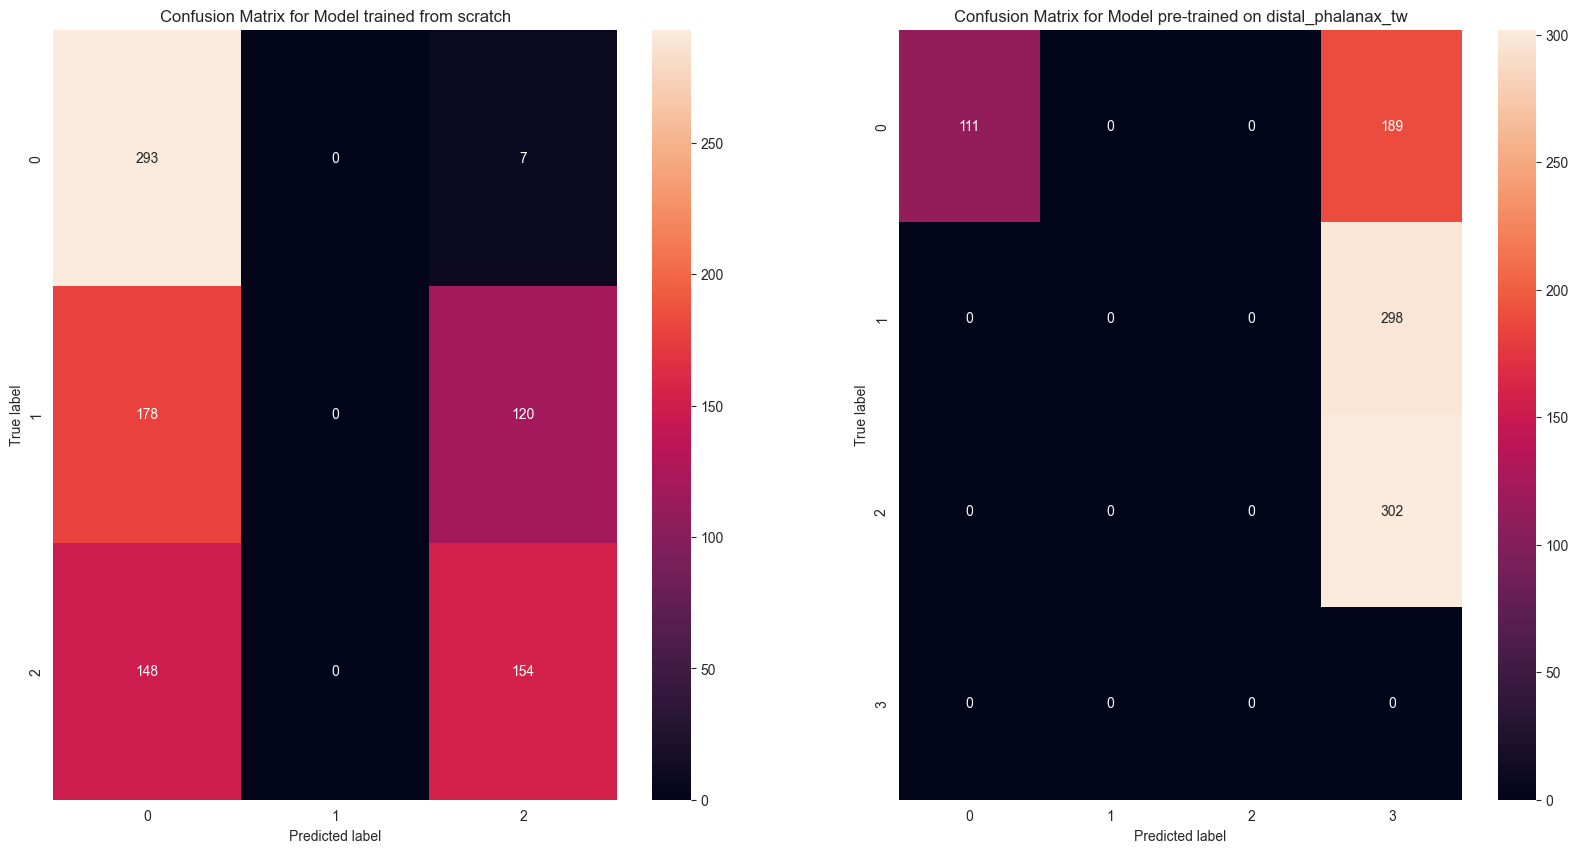

Pre-training model on dataset cbf


Training FCN on cbf dataset: 0epoch [00:00, ?epoch/s]

29/29 [==============================] - 0s 6ms/step - loss: 0.9756 - accuracy: 0.3867


Training FCN on gun_point_male_female dataset: 0epoch [00:00, ?epoch/s]

10/10 [==============================] - 0s 5ms/step - loss: 4.5218 - accuracy: 0.5253


Training FCN on cbf dataset: 0epoch [00:00, ?epoch/s]

29/29 [==============================] - 0s 3ms/step


C:\Users\timwi\AppData\Local\Temp\ipykernel_20560\4196572606.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


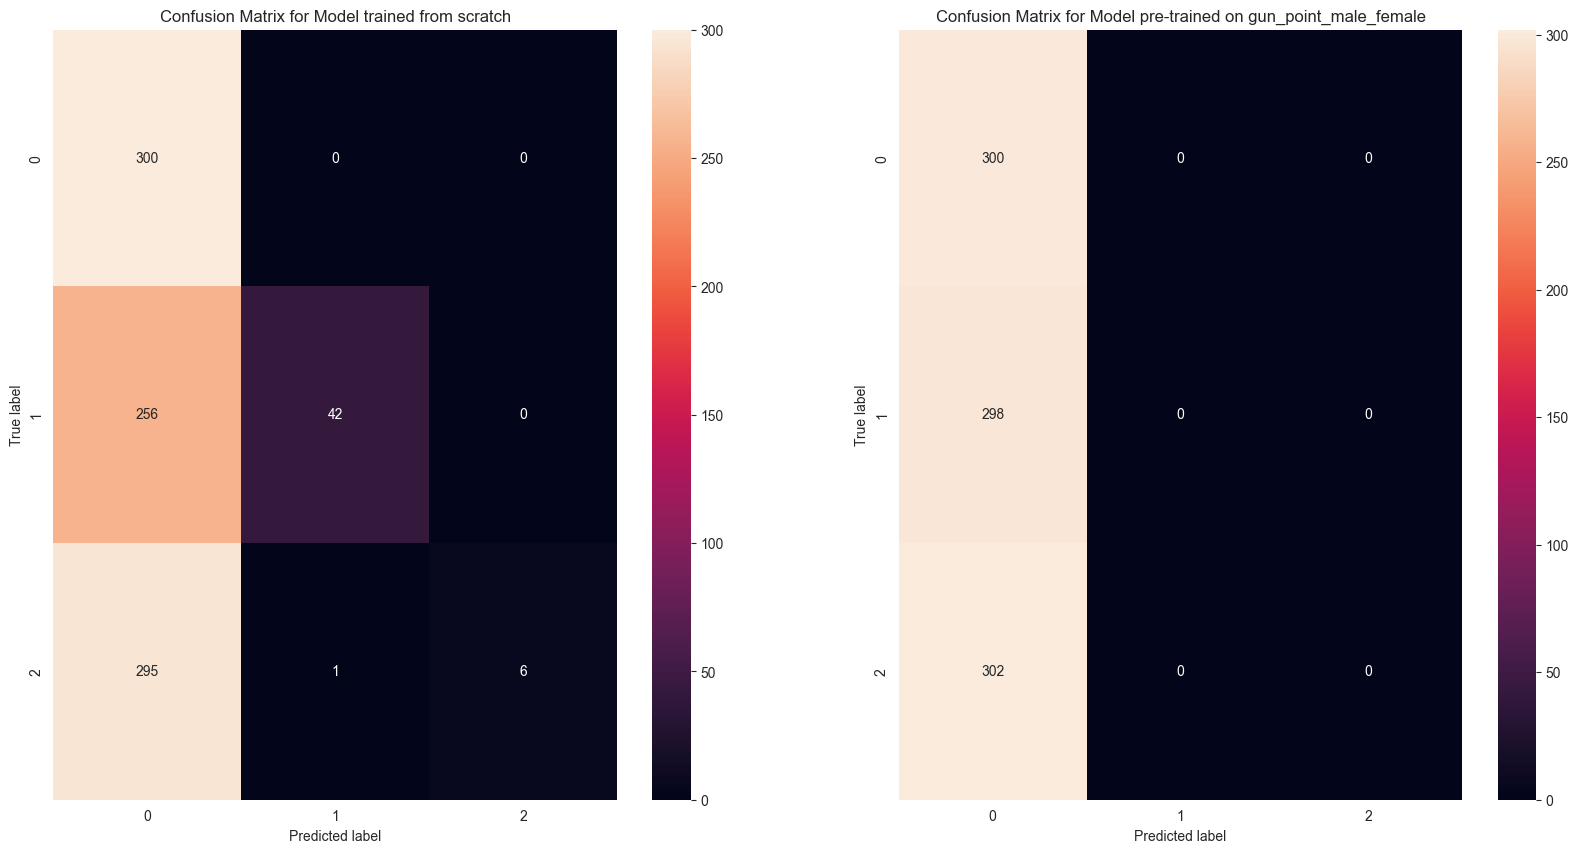

Training model targeting dataset distal_phalanax_tw


Pre-training on different datasets:   0%|          | 0/2 [00:00<?, ?datasets/s]

Pre-training model on dataset distal_phalanax_tw


Training FCN on distal_phalanax_tw dataset: 0epoch [00:00, ?epoch/s]

5/5 [==============================] - 0s 3ms/step - loss: 7.6537 - accuracy: 0.1295


Training FCN on cbf dataset: 0epoch [00:00, ?epoch/s]

29/29 [==============================] - 0s 4ms/step - loss: 1.0974 - accuracy: 0.3311


Training FCN on distal_phalanax_tw dataset: 0epoch [00:00, ?epoch/s]

5/5 [==============================] - 0s 2ms/step


C:\Users\timwi\AppData\Local\Temp\ipykernel_20560\4196572606.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


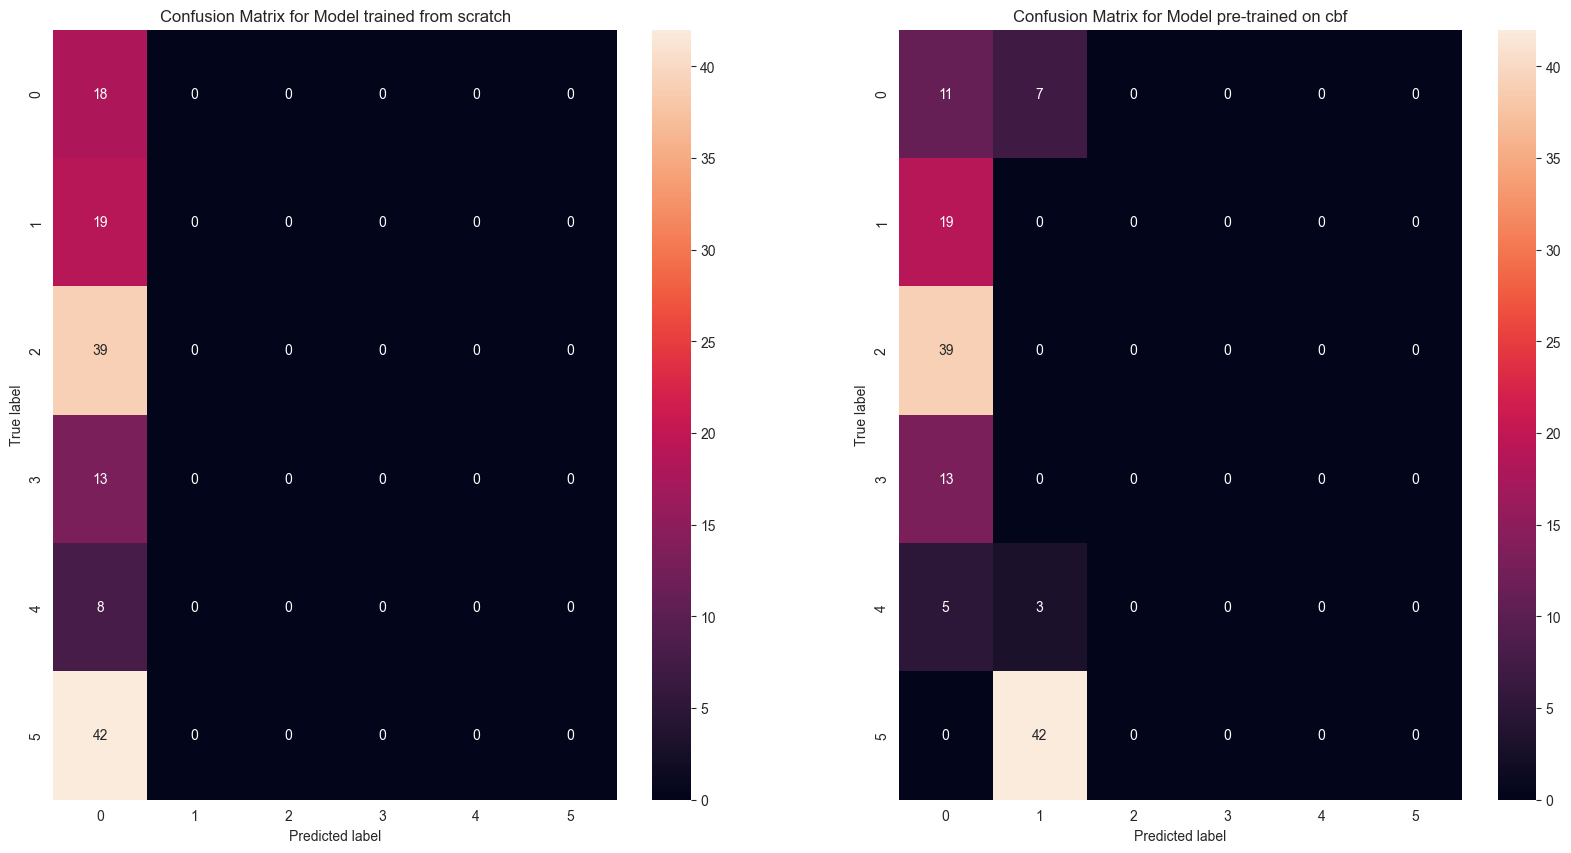

Pre-training model on dataset distal_phalanax_tw


Training FCN on distal_phalanax_tw dataset: 0epoch [00:00, ?epoch/s]

5/5 [==============================] - 0s 3ms/step - loss: 7.4487 - accuracy: 0.4317


Training FCN on gun_point_male_female dataset: 0epoch [00:00, ?epoch/s]

10/10 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.7089


Training FCN on distal_phalanax_tw dataset: 0epoch [00:00, ?epoch/s]

5/5 [==============================] - 0s 2ms/step


C:\Users\timwi\AppData\Local\Temp\ipykernel_20560\4196572606.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


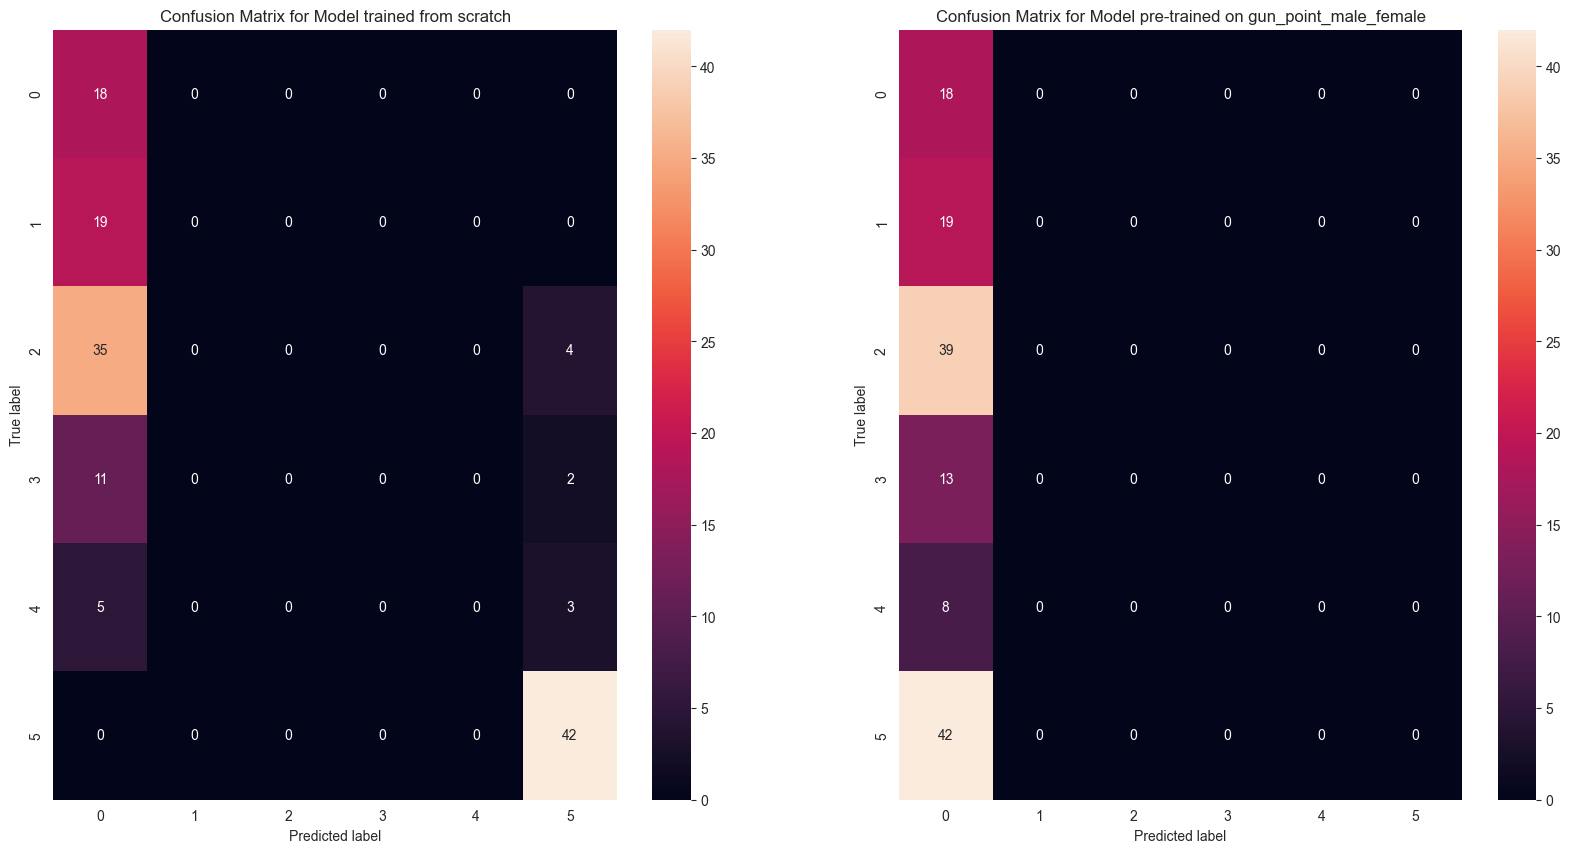

Training model targeting dataset gun_point_male_female


Pre-training on different datasets:   0%|          | 0/2 [00:00<?, ?datasets/s]

Pre-training model on dataset gun_point_male_female


Training FCN on gun_point_male_female dataset: 0epoch [00:00, ?epoch/s]

10/10 [==============================] - 0s 3ms/step - loss: 0.4765 - accuracy: 0.7373


Training FCN on cbf dataset: 0epoch [00:00, ?epoch/s]

29/29 [==============================] - 0s 4ms/step - loss: 1.0416 - accuracy: 0.3311


Training FCN on gun_point_male_female dataset: 0epoch [00:00, ?epoch/s]

10/10 [==============================] - 0s 2ms/step


C:\Users\timwi\AppData\Local\Temp\ipykernel_20560\4196572606.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


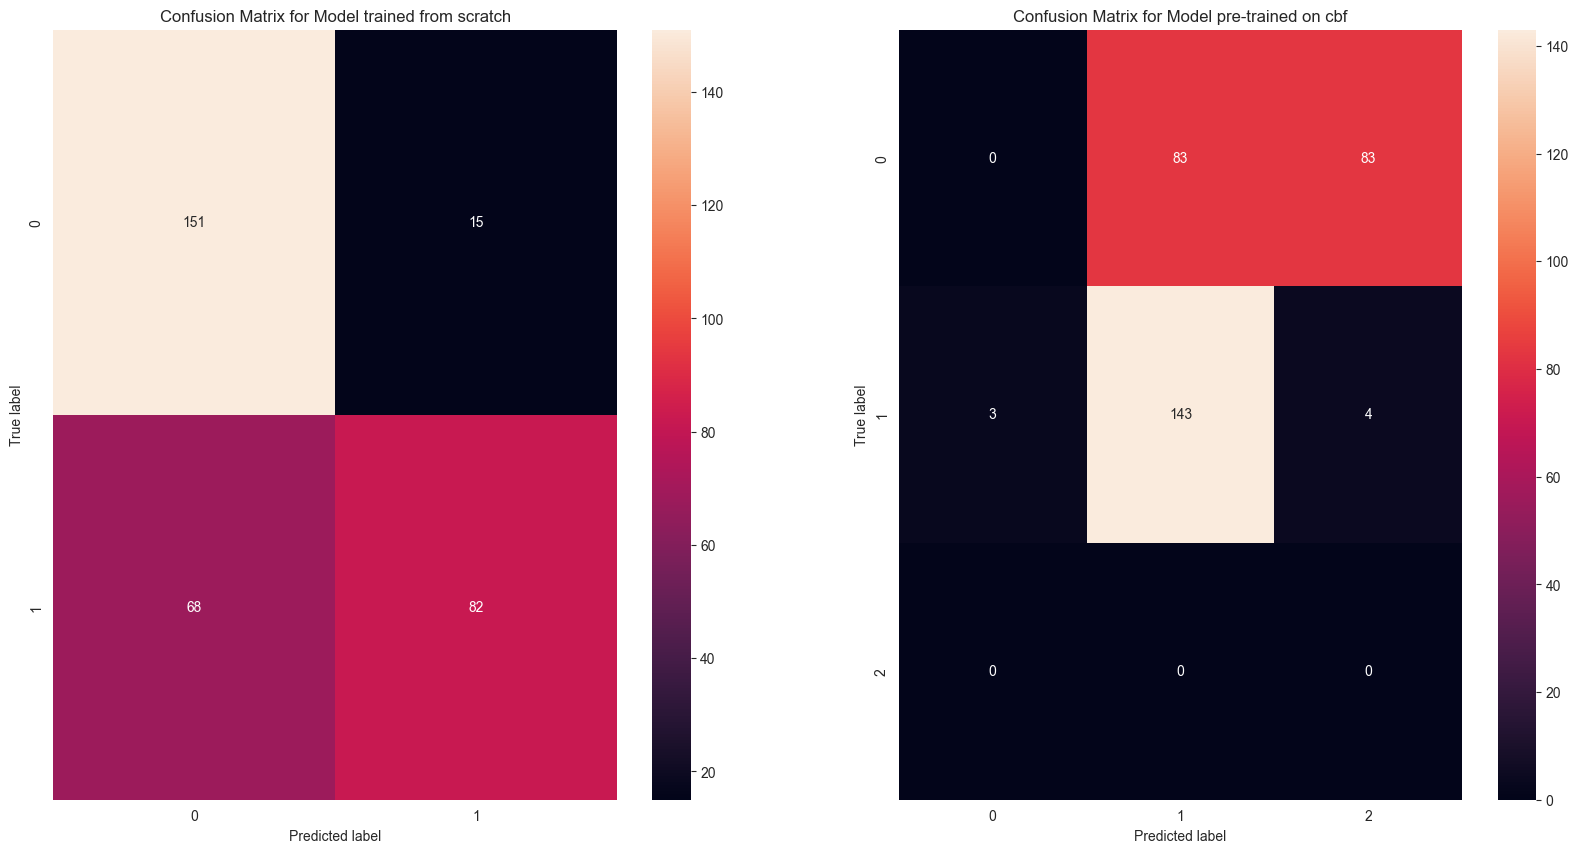

Pre-training model on dataset gun_point_male_female


Training FCN on gun_point_male_female dataset: 0epoch [00:00, ?epoch/s]

10/10 [==============================] - 0s 3ms/step - loss: 2.1784 - accuracy: 0.5601


Training FCN on distal_phalanax_tw dataset: 0epoch [00:00, ?epoch/s]

5/5 [==============================] - 0s 3ms/step - loss: 3.7637 - accuracy: 0.4317


Training FCN on gun_point_male_female dataset: 0epoch [00:00, ?epoch/s]

10/10 [==============================] - 0s 2ms/step


C:\Users\timwi\AppData\Local\Temp\ipykernel_20560\4196572606.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


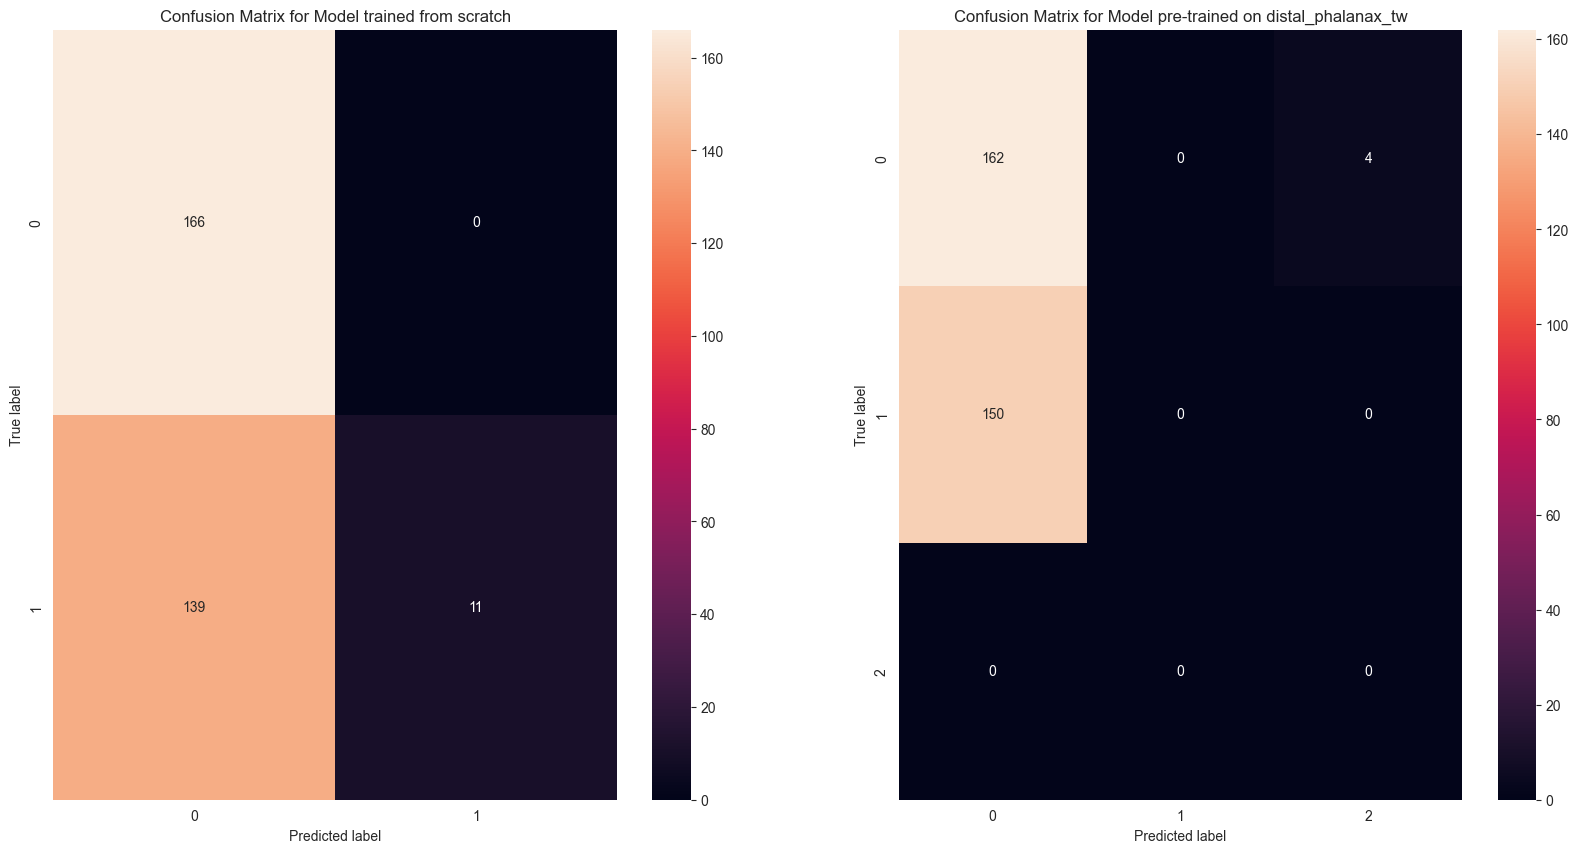

In [7]:
transfer_learning_for_all_datasets(USED_DATASETS)